In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.models import Model
import os
import tensorflow.keras

C:\Users\Azaghast\Anaconda3\envs\tf2-gpu-cuda10\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Azaghast\Anaconda3\envs\tf2-gpu-cuda10\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
train_dir = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Train"
test_dir = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Test"
val_dir = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Validation"
fear_train = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Train\\fear_train"
fear_test = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Test\\fear_test"
fear_val = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Validation\\fear_val"
others_train = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Train\\others_train"
others_test = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Test\\others_test"
others_val = "C:\\Users\\Azaghast\\Downloads\\Audio_Speech_Actors_01-24\\Validation\\others_val"

In [4]:
num_fear_tr = len(os.listdir(fear_train))
num_fear_val = len(os.listdir(fear_val))
num_fear_test = len(os.listdir(fear_test))

num_others_tr = len(os.listdir(others_train))
num_others_val = len(os.listdir(others_val))
num_others_test = len(os.listdir(others_test))

print(num_fear_tr,num_fear_val,num_fear_test,num_others_tr,num_others_val,num_others_test)

157 36 0 157 36 0


In [5]:
'''high = 0
for subdir, dir,files in os.walk(train_dir):#train has highest mfccs.shape[1] as of this dataset
        for file in files:
            data, sr = librosa.load(os.path.join(subdir,file), res_type = 'kaiser_fast')
            mfccs = librosa.feature.mfcc(y = data, n_mfcc = 1000,sr=sr )
            if mfccs.shape[1] > high:
                high = mfccs.shape[1]
print(high)'''

"high = 0\nfor subdir, dir,files in os.walk(train_dir):#train has highest mfccs.shape[1] as of this dataset\n        for file in files:\n            data, sr = librosa.load(os.path.join(subdir,file), res_type = 'kaiser_fast')\n            mfccs = librosa.feature.mfcc(y = data, n_mfcc = 1000,sr=sr )\n            if mfccs.shape[1] > high:\n                high = mfccs.shape[1]\nprint(high)"

In [6]:
def split_train_val_test(dir_name):
    holder = []
    for subdir, dir,files in os.walk(dir_name):
        for file in files:
            data, sr = librosa.load(os.path.join(subdir,file), res_type = 'kaiser_fast')
            mfccs = librosa.feature.mfcc(y = data, n_mfcc = 1000,sr=sr )
            mfccs_padded = np.zeros((128,216))
            for i in range(128):
                for j in range(len(mfccs[0])):
                    mfccs_padded[i][j] = mfccs[i][j]
            if int(file[7:8])==6:
                num = 0
            else:
                num = 1
            arr = mfccs_padded, num    
            holder.append(arr)
    return zip(*holder)

In [7]:
x_train, y_train = split_train_val_test(train_dir)

In [8]:
x_val, y_val = split_train_val_test(val_dir)

In [ ]:
#x_test, y_test = split_train_val_test(test_dir)

In [9]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
#x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
#y_test = np.asarray(y_test)

print(x_train.shape)
print(x_val.shape)
#print(x_test.shape)

(314, 128, 216)
(72, 128, 216)


In [10]:
x_train = x_train.reshape((x_train.shape[0],128,216,1))
x_val = x_val.reshape((x_val.shape[0],128,216,1))
#x_test = x_test.reshape((x_test.shape[0],128,216,1))

print(y_train.shape)
print(x_train.shape)
print(x_val.shape)

(314,)
(314, 128, 216, 1)
(72, 128, 216, 1)


In [45]:
#simple cnn baseline

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

class custom_callback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_accuracy'))>0.9:
            print("Training accuracy > 90 % so training has been stopped")
            self.model.stop_training=True

callback = custom_callback()

model = Sequential()
model.add(Conv2D(128,3,input_shape=(128,216,1),activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 214, 128)     1280      
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 214, 128)     512       
_________________________________________________________________
activation_9 (Activation)    (None, 126, 214, 128)     0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 107, 128)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 862848)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 862849    
Total params: 864,641
Trainable params: 864,385
Non-trainable params: 256
______________________________________________

In [46]:
EPOCHS = 40

history = model.fit(x_train,y_train,batch_size=16,epochs=EPOCHS,shuffle=True,validation_data=(x_val,y_val),callbacks=[callback])

Train on 314 samples, validate on 72 samples
Epoch 1/40
314/314 [==============================] - 2s 6ms/sample - loss: 34.6696 - accuracy: 0.5892 - val_loss: 10.0524 - val_accuracy: 0.7083
Epoch 2/40
314/314 [==============================] - 1s 4ms/sample - loss: 3.9579 - accuracy: 0.8089 - val_loss: 2.4470 - val_accuracy: 0.8611
Epoch 3/40
314/314 [==============================] - 1s 4ms/sample - loss: 3.0761 - accuracy: 0.8185 - val_loss: 4.9518 - val_accuracy: 0.7361
Epoch 4/40
314/314 [==============================] - 1s 4ms/sample - loss: 1.2266 - accuracy: 0.9140 - val_loss: 2.1787 - val_accuracy: 0.8472
Epoch 5/40
314/314 [==============================] - 1s 4ms/sample - loss: 0.5409 - accuracy: 0.9427 - val_loss: 4.5832 - val_accuracy: 0.7500
Epoch 6/40
314/314 [==============================] - 1s 4ms/sample - loss: 0.7905 - accuracy: 0.9522 - val_loss: 1.6825 - val_accuracy: 0.8611
Epoch 7/40
314/314 [==============================] - 1s 4ms/sample - loss: 0.1135 - accu

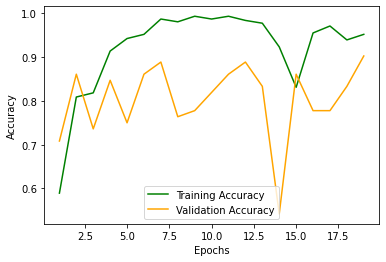

In [47]:
history_obj = history.history
epochs = [i for i in range(1,19+1)]
plt.plot(epochs,history_obj['accuracy'],color='green',label='Training Accuracy')
plt.plot(epochs,history_obj['val_accuracy'],color='orange',label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

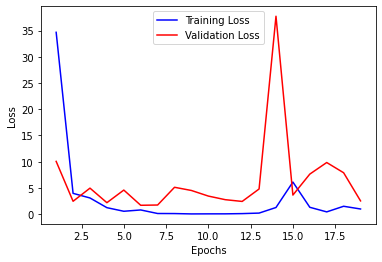

In [48]:
plt.plot(epochs,history_obj['loss'],color='blue',label='Training Loss')
plt.plot(epochs,history_obj['val_loss'],color='red',label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
pred = [0 if i <= 0.5 else 1 for i in pred]
report = classification_report(y_val,pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.89      0.89      0.89        36

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72



In [41]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

class custom_callback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
            print("Validation accuracy > 90 % so training has been stopped")
            self.model.stop_training=True

callback = custom_callback()

model = Sequential()
model.add(Conv2D(32,3,input_shape=(128,216,1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(128,3))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 214, 32)      320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 126, 214, 32)      128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 126, 214, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 107, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 107, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 105, 64)       18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 61, 105, 64)      

In [42]:
EPOCHS = 100

history = model.fit(x_train,y_train,batch_size=16,epochs=EPOCHS,shuffle=True,validation_data=(x_val,y_val),callbacks=[callback])

Train on 314 samples, validate on 72 samples
Epoch 1/100
314/314 [==============================] - 2s 6ms/sample - loss: 10.7640 - accuracy: 0.5287 - val_loss: 1.9728 - val_accuracy: 0.5833
Epoch 2/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.8531 - accuracy: 0.7229 - val_loss: 0.7355 - val_accuracy: 0.7361
Epoch 3/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.6799 - accuracy: 0.7006 - val_loss: 0.3889 - val_accuracy: 0.8472
Epoch 4/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.4849 - accuracy: 0.7611 - val_loss: 0.3912 - val_accuracy: 0.8333
Epoch 5/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.5109 - accuracy: 0.7580 - val_loss: 0.4425 - val_accuracy: 0.8056
Epoch 6/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.3306 - accuracy: 0.8662 - val_loss: 0.3781 - val_accuracy: 0.8611
Epoch 7/100
314/314 [==============================] - 1s 3ms/sample - loss: 0.3777 

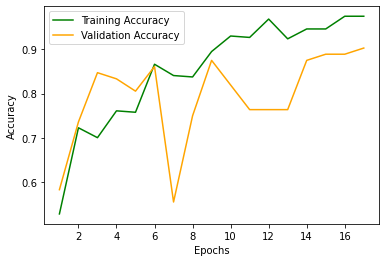

In [44]:
history_obj = history.history
epochs = [i for i in range(1,17+1)]
plt.plot(epochs,history_obj['accuracy'],color='green',label='Training Accuracy')
plt.plot(epochs,history_obj['val_accuracy'],color='orange',label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

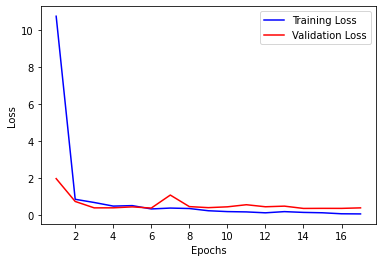

In [45]:
plt.plot(epochs,history_obj['loss'],color='blue',label='Training Loss')
plt.plot(epochs,history_obj['val_loss'],color='red',label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
pred = [0 if i <= 0.5 else 1 for i in pred]
report = classification_report(y_val,pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.91      0.89      0.90        36

    accuracy                           0.90        72
   macro avg       0.90      0.90      0.90        72
weighted avg       0.90      0.90      0.90        72

